In [1]:
import numpy as np
import matplotlib.pyplot as plt

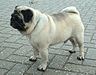

In [2]:
from PIL import Image

image = Image.open("pug.jpg")
image

In [3]:
x0 = np.array(image).astype(np.float32) / 255.0
x0.shape

(75, 96, 3)

In [4]:
class Diffusion:
    def __init__(self, diff_steps = 300):
        self.diff_steps = diff_steps
        self.betas = np.linspace(1e-4, 0.02, diff_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)
        
    def forward(self, x_0, t):
        epsilon = np.random.randn(*x_0.shape)
        alpha_bar = self.alpha_bars[t]
        x_t = np.sqrt(alpha_bar) * x_0 + np.sqrt(1 - alpha_bar) * epsilon
        return x_t, epsilon



In [5]:
model = Diffusion()

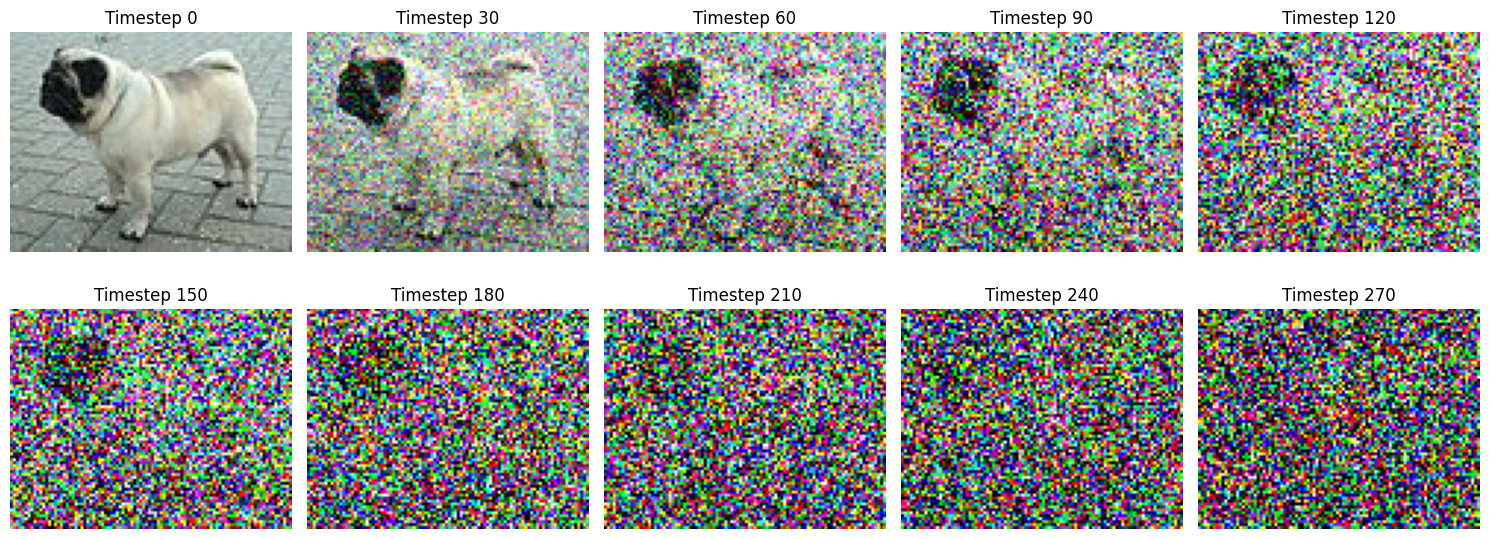

In [6]:
timesteps = [i for i in range(0, model.diff_steps, model.diff_steps // 10)]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, t in enumerate(timesteps):
    row = i // 5
    col = i % 5
    xt, epsilon = model.forward(x0, t)
    axes[row, col].imshow(np.clip(xt, 0, 1))
    axes[row, col].set_title(f"Timestep {t}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# For sake of simplicity, we'll use mlp rather than UNet for reversing the diffusion process

# Taken from CNN implementation
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.random.randn(output_size) * 0.1

    def forward(self, x):
        self.input = x
        return self.weights @ x + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.outer(grad_output, self.input)
        self.grad_biases = grad_output

        return self.weights.T @ grad_output

    def update(self, lr):
        self.weights -= lr * self.grad_weights
        self.biases -= lr * self.grad_biases

class Relu:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)

    def update(self, lr):
        for layer in self.layers:
            if hasattr(layer, "update"):
                layer.update(lr)

class MSE:
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return np.mean((pred - target) ** 2)

    def backward(self):
        return 2 * (self.pred - self.target) / self.pred.size

In [8]:
model = Model([
    Dense(784 + 128, 512), # 784 from image 128 from our t embeddings
    Relu(),
    Dense(512, 512),
    Relu(),
    Dense(512, 784)
    
])

diffusion_model = Diffusion()

In [9]:
def timestep_embedding(t, dim=128):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = t * emb
    return np.concatenate([np.sin(emb), np.cos(emb)]) * 0.1


def train(model, diffusion_model, trainX, epoch = 100):
    loss_fn = MSE()
    lr = 1e-3

    for i in range(epoch):
        loss = 0
        for x_0 in trainX:
            T = diffusion_model.diff_steps
            t = np.random.randint(0, T - 1)
            x_t, epsilon = diffusion_model.forward(x_0, t)
            
            t_emb = timestep_embedding(t / T, dim=128)
            x_in = np.concatenate([x_t.flatten(), t_emb])
    
            epsilon_pred = model.forward(x_in)
            loss += loss_fn.forward(epsilon_pred, epsilon.flatten())
    
            model.backward(loss_fn.backward())
            model.update(lr)
        
        print(f"Epoch {i}: loss is {loss / len(trainX)}")

In [10]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.int32)

X = X / 255.0
X = X.reshape(-1, 28, 28)

X_train, X_test = X[:-10], X[-10:]
y_train, y_test = y[:-10], y[-10:]

In [ ]:
train(model, diffusion_model, X_train)

Epoch 0: loss is 1.1874776608856272
Epoch 1: loss is 1.012870442306007
Epoch 2: loss is 1.007699020502658
Epoch 3: loss is 1.0052216443485165
Epoch 4: loss is 1.0036552876796667
Epoch 5: loss is 1.0029682876330577
Epoch 6: loss is 1.0021332172346
Epoch 7: loss is 1.0016400349840466
Epoch 8: loss is 1.001357203664249
Epoch 9: loss is 1.000977986638981
Epoch 10: loss is 1.001477447566
Epoch 11: loss is 1.0008194900345901
Epoch 12: loss is 1.0009356832656948
Epoch 13: loss is 1.0002867199034595


In [15]:
def iterative_denoise(model, diffusion_model, x_t, start_t, embedding_dim=128):
    x = x_t.flatten()
    
    for t in reversed(range(start_t + 1)):
        t_emb = timestep_embedding(t / diffusion_model.diff_steps, dim=embedding_dim)
        model_input = np.concatenate([x, t_emb])
        
        epsilon_pred = model.forward(model_input)
        
        alpha = diffusion_model.alphas[t]
        alpha_bar = diffusion_model.alpha_bars[t]
        beta = diffusion_model.betas[t]
        
        mean = (1 / np.sqrt(alpha)) * (x - (beta / np.sqrt(1 - alpha_bar)) * epsilon_pred)
        
        noise = np.random.randn(*x.shape)
        x = mean + np.sqrt(beta) * noise
    
    return x.reshape(28, 28)


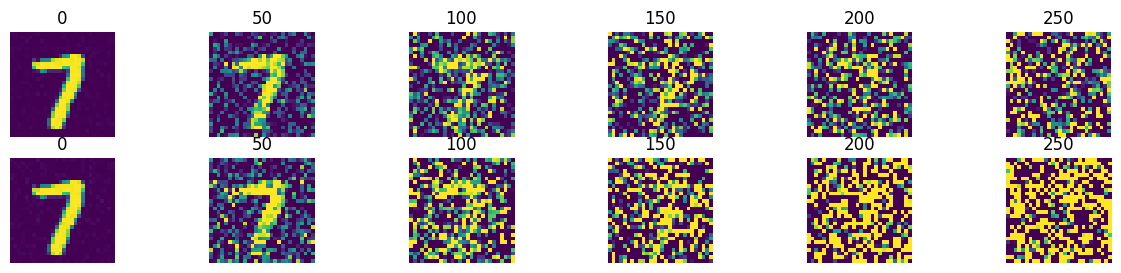

In [16]:
T = diffusion_model.diff_steps
timesteps = [i for i in range(0, T, 50)]

corrupted = []
predicted = []

for x_0 in X_test:
    sample_corrupted = []
    sample_predicted = []
    for t in timesteps:
        c = diffusion_model.forward(x_0, t)[0]
        p = iterative_denoise(model, diffusion_model, c, t, 128)
        
        sample_corrupted.append((t, c))
        sample_predicted.append((t, p))
    corrupted.append(sample_corrupted)
    predicted.append(sample_predicted)
    
    
    
fig, axes = plt.subplots(2, len(timesteps), figsize=(15, 3))

for idx, ((t, x_t), (_t, p)) in enumerate(zip(corrupted[0], predicted[0])):
    axes[0, idx].imshow(np.clip(x_t, 0, 1))
    axes[0, idx].set_title(t)
    axes[1, idx].imshow(np.clip(p, 0, 1))
    axes[1, idx].set_title(t)
    axes[0, idx].axis("off")
    axes[1, idx].axis("off")
